## Customer Churn Rate

In [1]:
# Import necessary libraries
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Data wragling

In [2]:
# import from csv
data0 = pd.read_csv('bankchurners.csv')
data1 = pd.read_csv('enriched_churn_data.csv')
data2 = pd.read_csv('basic_client_info.csv')

In [3]:
# merge all tables
data01 = pd.merge(data0, data1, on='clientnum')
data = pd.merge(data01, data2, on='clientnum')
df = pd.DataFrame(data=data)

In [4]:
pd.set_option('max_colwidth', 10)
pd.set_option('display.max_columns', 21)
df.sample(10)

,clientnum,attrition_flag,dependent_count,card_category,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio,total_relationship_count,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct,customer_age,gender,education_level,marital_status,income_category
5025,713431008,Existi...,5,Blue,36,3,0,3562.0,3562.0,0.000,5,0,0.753,4198,0.750,77,46,F,High S...,Married,Unknown
9804,715351983,Existi...,2,Blue,20,3,2,9761.0,8291.0,0.151,1,1470,0.796,14334,0.732,97,32,F,Unknown,Married,Less t...
6613,714823308,Existi...,3,Gold,35,3,3,15987.0,14014.0,0.123,2,1973,0.705,7345,0.463,98,55,F,College,Single,Less t...
5375,716311683,Existi...,4,Blue,36,1,2,32733.0,31285.0,0.044,4,1448,0.655,3452,0.862,54,43,M,College,Married,$80K -...
5751,708761733,Existi...,3,Blue,36,2,2,8279.0,6697.0,0.191,2,1582,0.760,4419,0.658,63,52,F,High S...,Married,Unknown
3212,716059608,Existi...,4,Blue,38,3,3,4894.0,3389.0,0.308,4,1505,0.780,3277,0.558,67,48,F,College,Single,Less t...
9620,721147383,Existi...,2,Blue,22,2,4,2448.0,708.0,0.711,4,1740,0.901,4087,0.841,81,37,F,High S...,Single,Less t...
5015,712292133,Attrit...,3,Blue,36,2,4,2330.0,36.0,0.985,4,2294,0.456,2107,0.333,40,45,F,College,Married,Less t...
2079,778255083,Existi...,1,Blue,42,3,3,3103.0,586.0,0.811,5,2517,0.881,4641,1.000,80,52,F,Uneduc...,Married,Less t...
6180,713868033,Existi...,1,Silver,36,2,2,34516.0,33032.0,0.043,2,1484,1.015,16373,0.900,114,53,M,College,Married,$80K -...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   clientnum                 10127 non-null  int64  
 1   attrition_flag            10127 non-null  object 
 2   dependent_count           10127 non-null  int64  
 3   card_category             10127 non-null  object 
 4   months_on_book            10127 non-null  int64  
 5   months_inactive_12_mon    10127 non-null  int64  
 6   contacts_count_12_mon     10127 non-null  int64  
 7   credit_limit              10127 non-null  float64
 8   avg_open_to_buy           10127 non-null  float64
 9   avg_utilization_ratio     10127 non-null  float64
 10  total_relationship_count  10127 non-null  int64  
 11  total_revolving_bal       10127 non-null  int64  
 12  total_amt_chng_q4_q1      10127 non-null  float64
 13  total_trans_amt           10127 non-null  int64  
 14  total_

### Data Cleaning

In [6]:
#make a copy
df_clean = df.copy()

In [7]:
#check duplicates
df_clean.duplicated().sum()

0

In [8]:
#check nulls
df_clean.attrition_flag.isna().sum()

0

In [9]:
## Pre-processing

In [10]:
categorical_cols = [c for c in df_clean.columns if df_clean[c].dtype == 'object']
categorical_cols               

['attrition_flag',
 'card_category',
 'gender',
 'education_level',
 'marital_status',
 'income_category']

In [11]:
numerical_cols = [n for n in df_clean.columns if df_clean[n].dtype != 'object']
numerical_cols  

['clientnum',
 'dependent_count',
 'months_on_book',
 'months_inactive_12_mon',
 'contacts_count_12_mon',
 'credit_limit',
 'avg_open_to_buy',
 'avg_utilization_ratio',
 'total_relationship_count',
 'total_revolving_bal',
 'total_amt_chng_q4_q1',
 'total_trans_amt',
 'total_ct_chng_q4_q1',
 'total_trans_ct',
 'customer_age']

In [12]:
numerical_cols = ['contacts_count_12_mon', 'months_on_book', 'months_inactive_12_mon']
df[numerical_cols].describe()

,contacts_count_12_mon,months_on_book,months_inactive_12_mon
count,10127....,10127....,10127....
mean,2.455317,35.928409,2.341167
std,1.106225,7.986416,1.010622
min,0.000000,13.000000,0.000000
25%,2.000000,31.000000,2.000000
50%,2.000000,36.000000,2.000000
75%,3.000000,40.000000,3.000000
max,6.000000,56.000000,6.000000


In [13]:
df_clean.attrition_flag.value_counts() #below the anual churning rate?

Existing Customer    8500
Attrited Customer    1627
Name: attrition_flag, dtype: int64

In [14]:
#Convert 'attrition_flag'to binary dtype
dict_ch = {
         'Existing Customer' : 0,
         'Attrited Customer' : 1,
         
        
    }
df_clean['churned'] = df_clean['attrition_flag']
df_clean.replace({"churned": dict_ch},inplace=True)

In [15]:
# Calculate the percentage of churned customers
num_churned = df_clean[df_clean["churned"] == 1].shape[0]
num_total = df_clean.shape[0]
percent_churned = (num_churned / num_total) * 100

# Format the result as a percentage
print("Percentage of churned customers: {:.2f}%".format(percent_churned))


Percentage of churned customers: 16.07%


In [16]:
df_clean

,clientnum,attrition_flag,dependent_count,card_category,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio,...,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct,customer_age,gender,education_level,marital_status,income_category,churned
0,806160108,Existi...,1,Blue,56,2,3,3193.0,676.0,0.788,...,1.831,1336,1.143,30,61,M,High S...,Married,$40K -...,0
1,804424383,Existi...,1,Blue,56,3,2,10215.0,9205.0,0.099,...,0.843,1904,1.000,40,63,M,Unknown,Married,$60K -...,0
2,708300483,Attrit...,0,Blue,56,4,3,7882.0,7277.0,0.077,...,1.052,704,0.143,16,66,F,Doctorate,Married,Unknown,1
3,808284783,Existi...,1,Blue,56,0,0,1438.3,1438.3,0.000,...,0.813,1951,1.095,44,62,F,Unknown,Married,Less t...,0
4,712720158,Existi...,1,Blue,56,2,3,13860.0,12208.0,0.119,...,1.255,1910,1.909,32,68,M,Graduate,Married,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,714082308,Attrit...,3,Blue,13,1,3,8656.0,8656.0,0.000,...,0.893,8056,0.935,89,39,M,High S...,Single,$80K -...,1
10123,710751033,Attrit...,1,Blue,13,1,3,4829.0,4829.0,0.000,...,0.836,8286,0.857,65,31,F,Graduate,Single,Less t...,1
10124,780118158,Existi...,0,Blue,13,2,4,3585.0,1165.0,0.675,...,0.812,15656,0.746,124,27,M,Graduate,Single,Less t...,0
10125,779082633,Existi...,2,Blue,13,2,3,4107.0,3128.0,0.238,...,0.647,14596,0.733,104,30,M,Uneduc...,Single,$60K -...,0


#### Observations

The annual churn rate for credit cards can vary greatly depending on the type of card and the target demographic. On average, it is common to see an annual churn rate of around 20% for credit cards. However, some high-end, premium credit cards may have a lower churn rate, while cards targeted towards subprime borrowers may have a higher churn rate.

It's important to note that a lower churn rate is typically seen as a positive sign for a credit card issuer, as it indicates that customers are satisfied with the card and less likely to switch to a different one. On the other hand, a higher churn rate can indicate that customers are not satisfied with the card or are switching to a different one with more attractive terms.

A preliminary overview of the dataset shows that around 83.93% of customers are active, while 16.07% have churned.

In [17]:
#Convert 'attrition_flag'to boolean dtype
dict_g = {
         'F' : ['Female'],
         'M' :[' Male'],
         
        
    }
df_clean['gender'] = df_clean['gender']
df_clean.replace({"gender": dict_g},inplace=True)

In [18]:
df.describe(include='object')

,attrition_flag,card_category,gender,education_level,marital_status,income_category
count,10127,10127,10127,10127,10127,10127
unique,2,4,2,7,4,6
top,Existi...,Blue,F,Graduate,Married,Less t...
freq,8500,9436,5358,3128,4687,3561


In [19]:
df_clean.describe().loc[['min','max','mean']].round(2)

,clientnum,dependent_count,months_on_book,months_inactive_12_mon,contacts_count_12_mon,credit_limit,avg_open_to_buy,avg_utilization_ratio,total_relationship_count,total_revolving_bal,total_amt_chng_q4_q1,total_trans_amt,total_ct_chng_q4_q1,total_trans_ct,customer_age,churned
min,7.0808...,0.00,13.00,0.00,0.00,1438.30,3.00,0.00,1.00,0.00,0.00,510.00,0.00,10.00,26.00,0.00
max,8.2834...,5.00,56.00,6.00,6.00,34516.00,34516.00,1.00,6.00,2517.00,3.40,18484.00,3.71,139.00,73.00,1.00
mean,7.3917...,2.35,35.93,2.34,2.46,8631.95,7469.14,0.27,3.81,1162.81,0.76,4404.09,0.71,64.86,46.33,0.16


In [20]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10127 entries, 0 to 10126
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   clientnum                 10127 non-null  int64  
 1   attrition_flag            10127 non-null  object 
 2   dependent_count           10127 non-null  int64  
 3   card_category             10127 non-null  object 
 4   months_on_book            10127 non-null  int64  
 5   months_inactive_12_mon    10127 non-null  int64  
 6   contacts_count_12_mon     10127 non-null  int64  
 7   credit_limit              10127 non-null  float64
 8   avg_open_to_buy           10127 non-null  float64
 9   avg_utilization_ratio     10127 non-null  float64
 10  total_relationship_count  10127 non-null  int64  
 11  total_revolving_bal       10127 non-null  int64  
 12  total_amt_chng_q4_q1      10127 non-null  float64
 13  total_trans_amt           10127 non-null  int64  
 14  total_

In [22]:
df_churned = df_clean[df_clean['churned'] == 1]

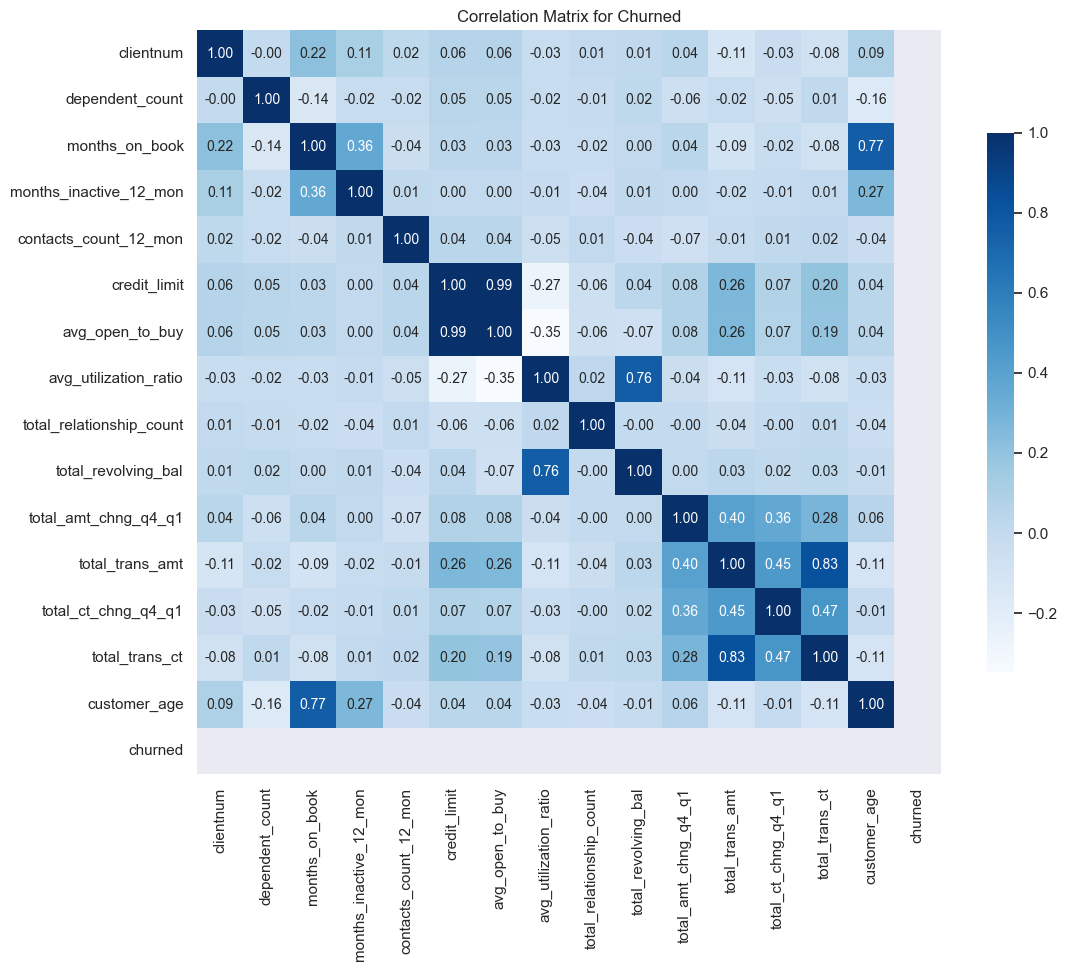

In [23]:
# Generate a correlation matrix
corr_matrix = df_churned.corr()

plt.figure(figsize=(12, 10))
sns.set(font_scale=1)
sns.heatmap(corr_matrix,
            cmap='Blues',
            annot=True,
            fmt='.2f',
            square=True,
            annot_kws={'size': 10},
            cbar_kws={'shrink': 0.7},
            xticklabels=1,
            yticklabels=1)
plt.xticks(rotation=90)
plt.title('Correlation Matrix for Churned')
plt.show()

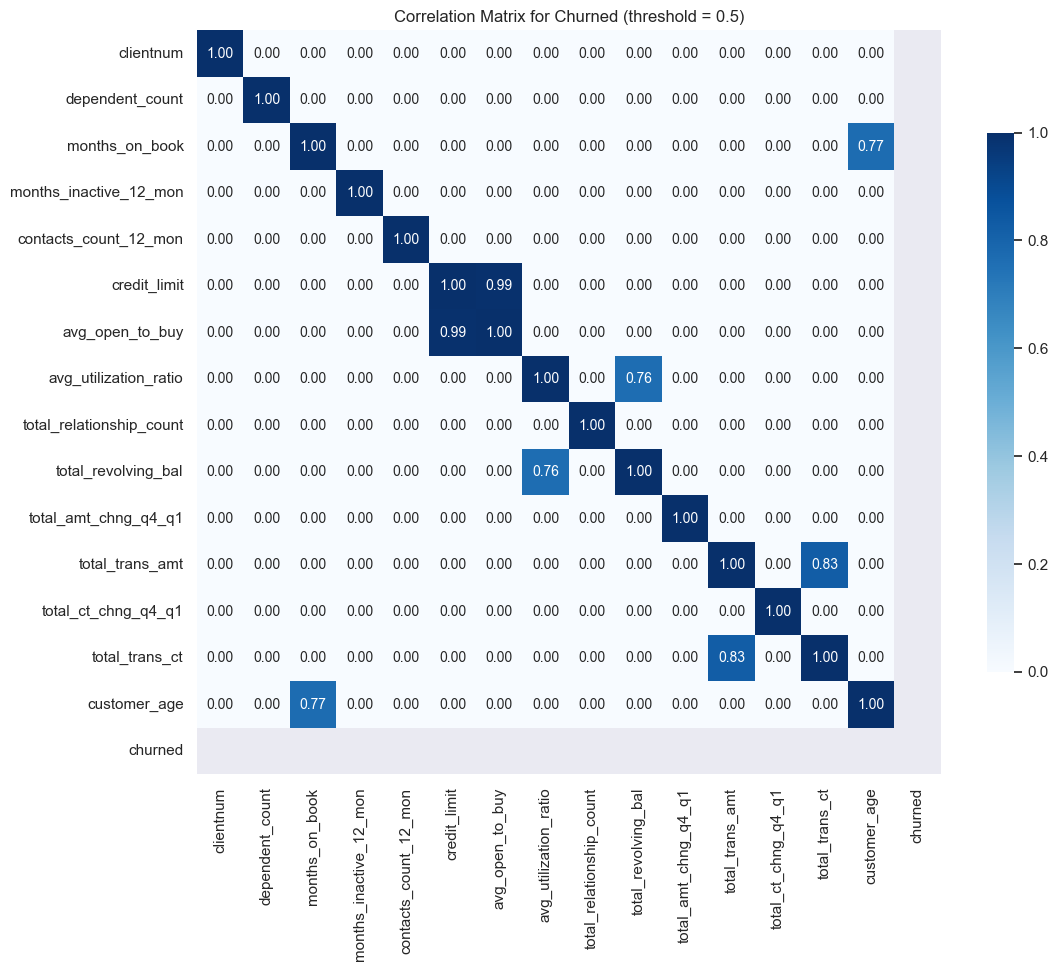

In [24]:
# Generate a correlation matrix
corr_matrix = df_churned.corr()

# Set a threshold for displaying correlations
thresh = 0.5
corr_matrix[abs(corr_matrix) < thresh] = 0

plt.figure(figsize=(12, 10))
sns.set(font_scale=1)
sns.heatmap(corr_matrix,
            cmap='Blues',
            annot=True,
            fmt='.2f',
            square=True,
            annot_kws={'size': 10},
            cbar_kws={'shrink': 0.7},
            xticklabels=1,
            yticklabels=1)
plt.xticks(rotation=90)
plt.title('Correlation Matrix for Churned (threshold = {})'.format(thresh))
plt.show()

In [31]:
# Convert categorical columns to integer codes
df_clean['attrition_flag'] = pd.factorize(df_clean['attrition_flag'])[0]
df_clean['card_category'] = pd.factorize(df_clean['card_category'])[0]
df_clean['gender'] = pd.factorize(df_clean['gender'])[0]
df_clean['education_level'] = pd.factorize(df_clean['education_level'])[0]
df_clean['marital_status'] = pd.factorize(df_clean['marital_status'])[0]
df_clean['income_category'] = pd.factorize(df_clean['income_category'])[0]

# Create DMatrix object with categorical support
dtrain = xgb.DMatrix(data=df_clean.drop('churned', axis=1),
                     label=df_clean['churned'],
                     enable_categorical=True)

# Split the dataset into training and testing sets
X = df_clean.drop('churned', axis=1)
y = df_clean['churned']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

# Create the XGBoost classifier
clf = xgb.XGBClassifier(objective='binary:logistic',
                        max_depth=3,
                        learning_rate=0.1,
                        n_estimators=100)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 1.0000


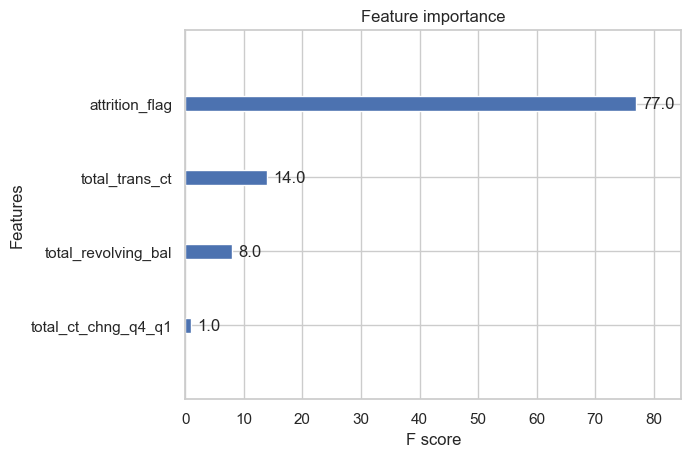

In [32]:
# Plot feature importance
xgb.plot_importance(clf)
plt.show()

 - In the context of XGBoost, the F-score refers to the feature importance score calculated for each feature. The F-score is a measure of the total reduction in the impurity of the model when splitting on a particular feature. It is used to rank the importance of features in the model and can be used to identify the most relevant features for prediction. Features with higher F-scores are considered more important to the model.

### Economics

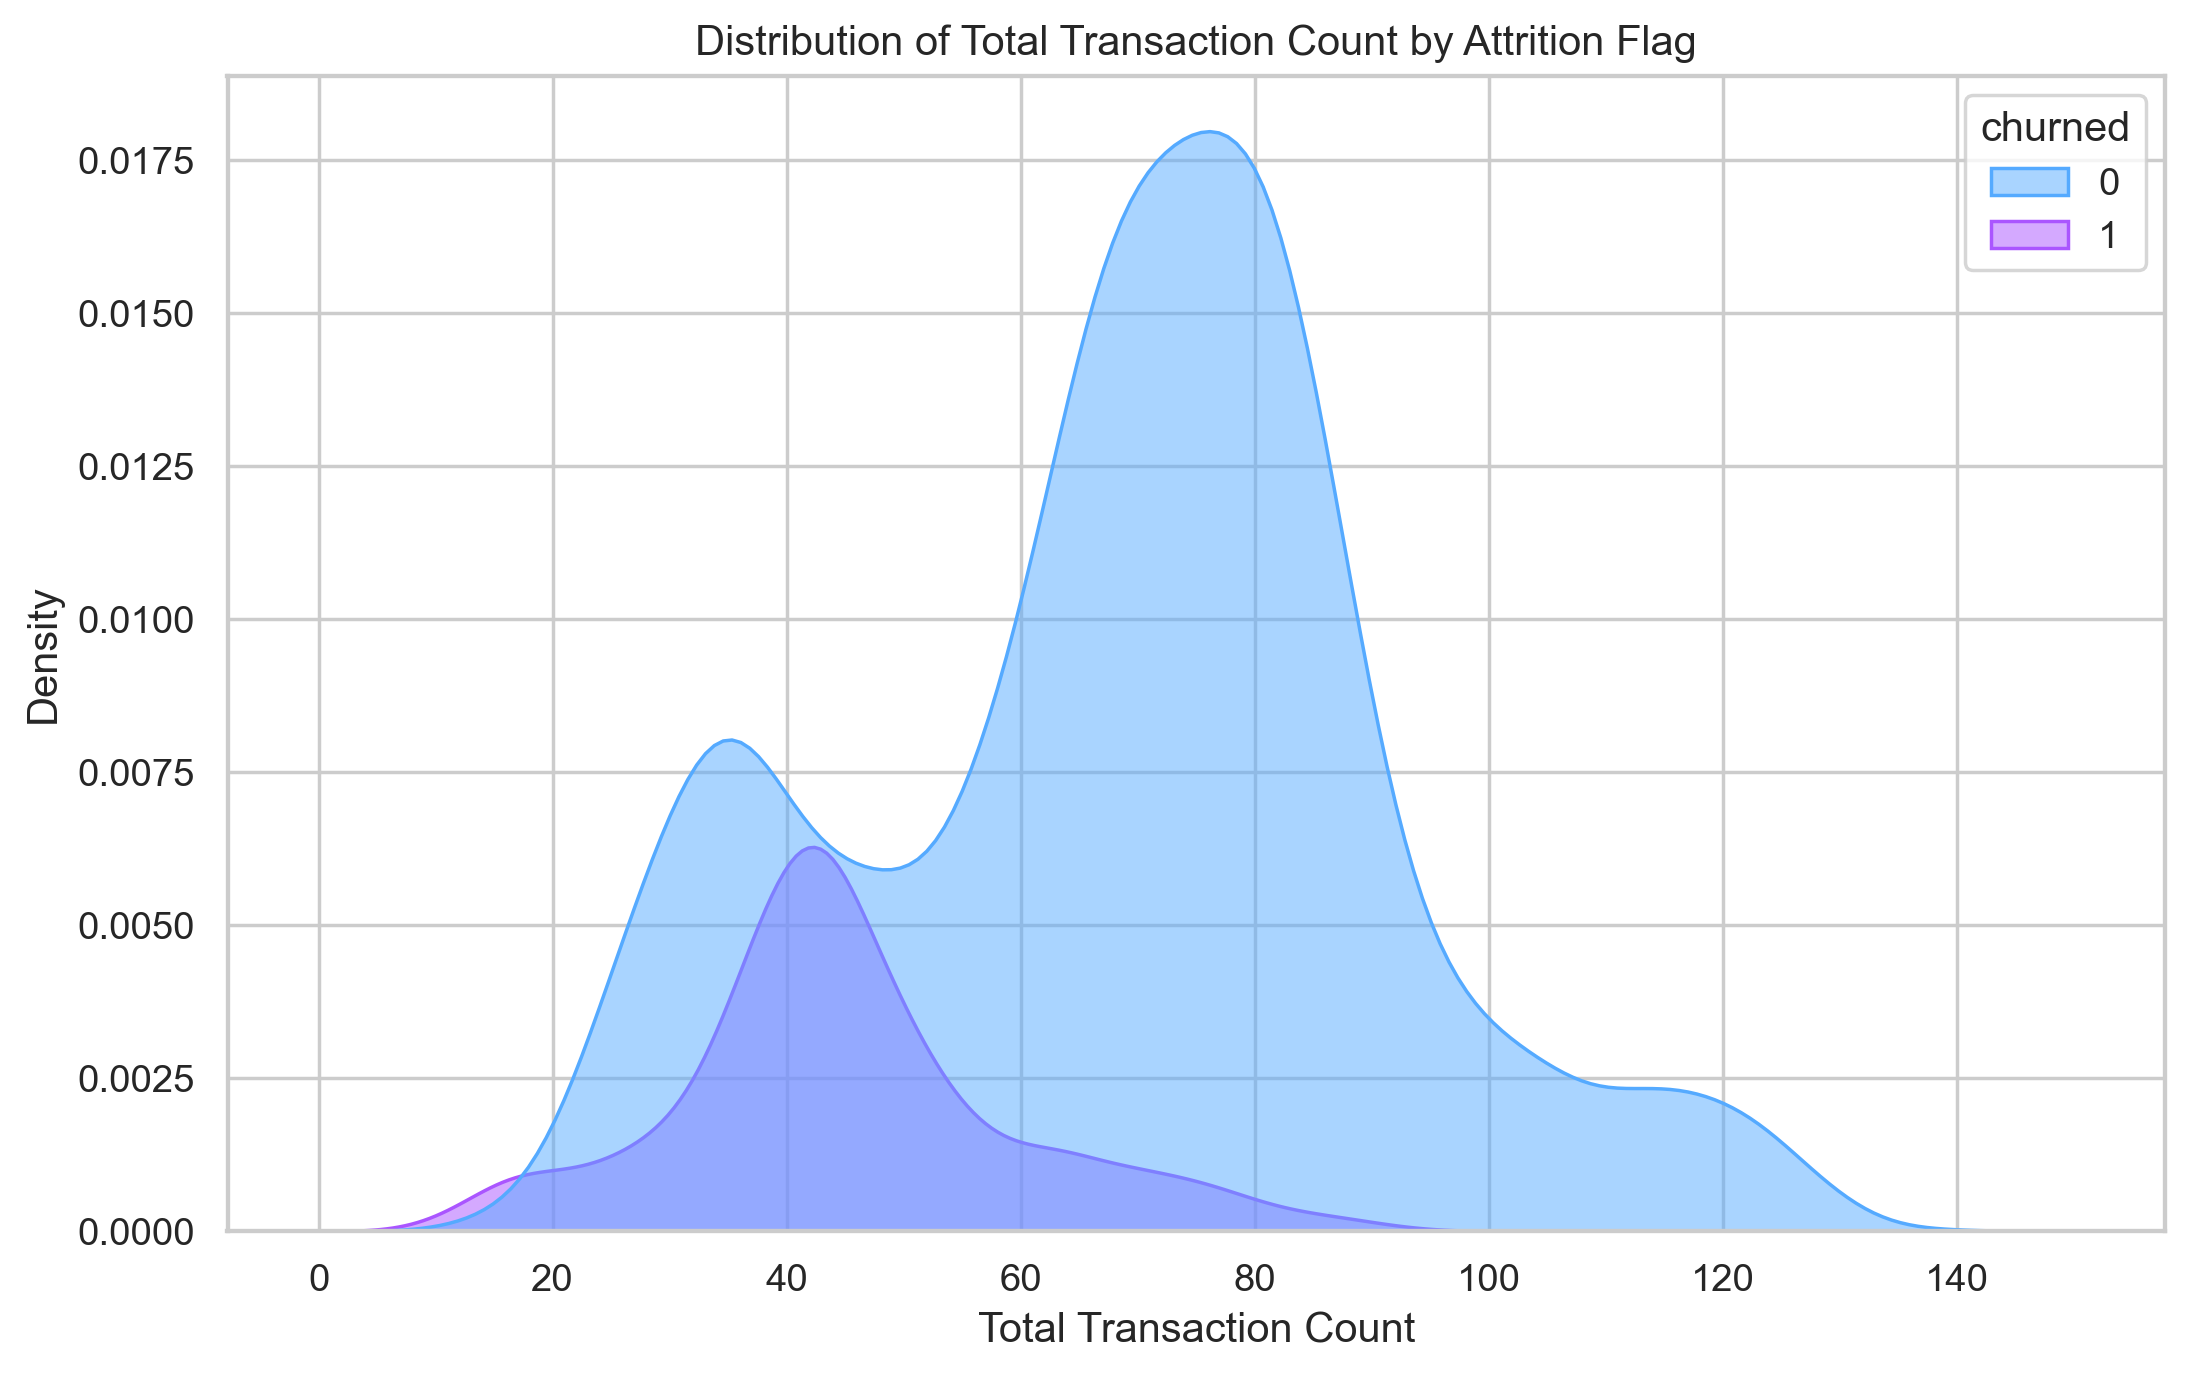

In [36]:
# Plot distribution of total transaction count by attrition flag
plt.figure(figsize=(10, 6),dpi=250)
sns.kdeplot(data=df_clean,
            x='total_trans_ct',
            hue='churned',
            fill=True,
            alpha=0.5,
            palette='cool')
plt.title('Distribution of Total Transaction Count by Attrition Flag')
plt.xlabel('Total Transaction Count')
plt.ylabel('Density')
plt.show()

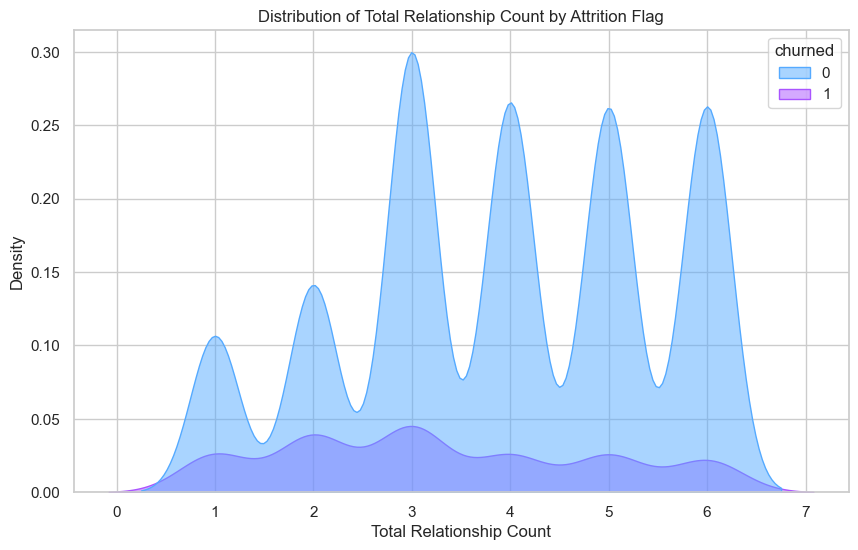

In [34]:
# Plot distribution of total relationship count by attrition flag
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_clean,
            x='total_relationship_count',
            hue='churned',
            fill=True,
            alpha=0.5,
            palette='cool')
plt.title('Distribution of Total Relationship Count by Attrition Flag')
plt.xlabel('Total Relationship Count')
plt.ylabel('Density')
plt.show()

### User Activity

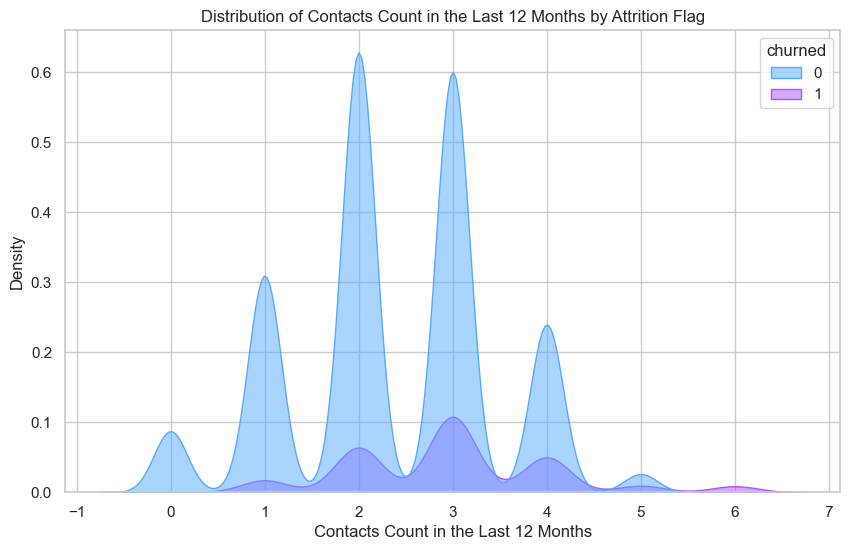

In [35]:
# Set style
sns.set_style('whitegrid')

# Create distribution plot of contacts count by attrition flag
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_clean,
            x='contacts_count_12_mon',
            hue='churned',
            fill=True,
            alpha=0.5,
            palette='cool')
plt.title(
    'Distribution of Contacts Count in the Last 12 Months by Attrition Flag')
plt.xlabel('Contacts Count in the Last 12 Months')
plt.ylabel('Density')
plt.show()

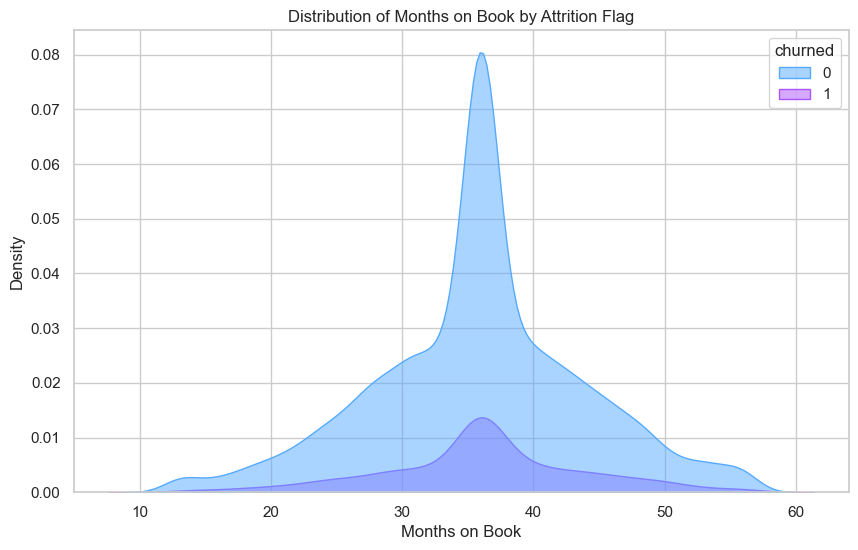

In [30]:
# Plot distribution of months on book by attrition flag
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_clean,
            x='months_on_book',
            hue='churned',
            fill=True,
            alpha=0.5,
            palette='cool')
plt.title('Distribution of Months on Book by Attrition Flag')
plt.xlabel('Months on Book')
plt.ylabel('Density')
plt.show()

 - Customer retention: Since the mean number of months on the book is 36, we can assume that a significant proportion of the customers have been with the bank for a relatively long period of time. This could indicate that the bank has been successful in retaining its customers over a longer period of time.